The following are comparisons of the different image interpolation algorithms available in OpenCV. The exampes are shown for both upsizing and downsizing images. Also shown is a comparison of the speed of the different algorithms.

The algorithms are: (descriptions are from the OpenCV documentation)
 - INTER_NEAREST - a nearest-neighbor interpolation
 - INTER_LINEAR - a bilinear interpolation (used by default)
 - INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, 
   as it gives   moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
 - INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
 - INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

In [3]:
%pylab inline
import cv2
import imageio
import itertools
import matplotlib.gridspec as gridspec
import pandas as pd
import time

# standard images in imageio
ref_images = ["coffee.png", "page.png", "immunohistochemistry.png", "horse.png"] 
# Limit starting size
images_orig = [cv2.resize(imageio.imread(im), (400,400)) for im in ref_images] 
# interpolation methods to compare
methods=[("area", cv2.INTER_AREA), 
         ("nearest", cv2.INTER_NEAREST), 
         ("linear", cv2.INTER_LINEAR), 
         ("cubic", cv2.INTER_CUBIC), 
         ("lanczos4", cv2.INTER_LANCZOS4)]
# opencv version
print("opencv version", cv2.__version__)

Populating the interactive namespace from numpy and matplotlib


ImportError: No module named 'imageio'

In [2]:
# function to display images
def display(images, titles=['']):
    if isinstance(images[0], list):
        c = len(images[0])
        r = len(images)
        images = list(itertools.chain(*images))
    else:
        c = len(images)
        r = 1
    plt.figure(figsize=(4*c, 4*r))
    gs1 = gridspec.GridSpec(r, c, wspace=0, hspace=0)
    #gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes. 
    titles = itertools.cycle(titles)
    for i in range(r*c):
        im = images[i]
        title = titles.next()
        plt.subplot(gs1[i])
        # Don't let imshow doe any interpolation
        plt.imshow(im, cmap='gray', interpolation='none')
        plt.axis('off')
        if i < c:
            plt.title(title)
    plt.tight_layout()

## Upsampling comparison
Take a 50x50 image and rescale it to 400x400 pixels. For ease of comparison, the original and the rescaled are shown at the same size so the algorithm image quality can be compared. For updampling, area & nearest algorithms create jagged edges while the linear makes smoother edges. The cubic and Lanczos make the sharpest edges.

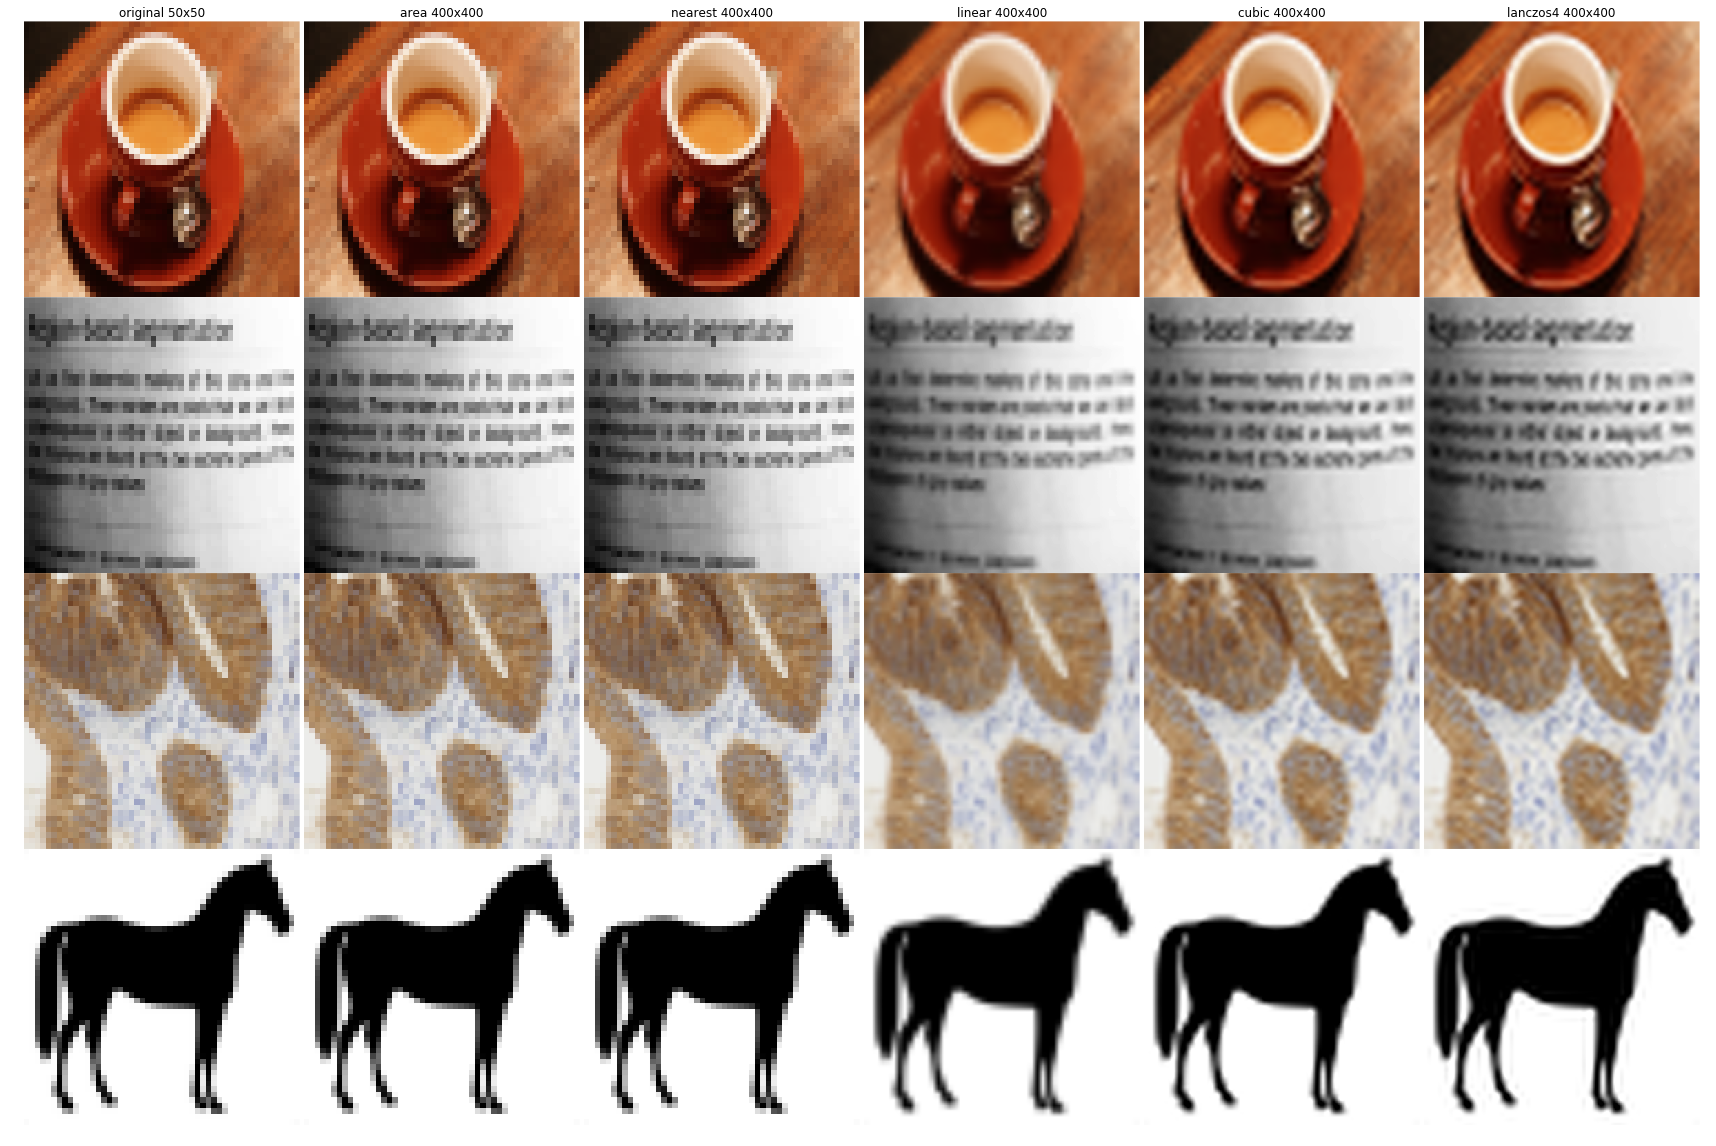

In [3]:
images_small = [cv2.resize(im, (50,50),interpolation=cv2.INTER_AREA) for im in images_orig]
image_set = [[cv2.resize(im, (400,400), interpolation=m[1]) for m in methods] for im in images_small]
image_set = [[ima,]+imb for ima, imb in zip(images_small, image_set)]
names = ["original 50x50",] + [m[0]+" 400x400" for m in methods]
display(image_set, names)
# plt.savefig("opencv_interpolation_upsample.jpg", dpi=75)

## Downsampling comparison
Take a 400x400 image and rescale it to 50x50 pixels. For ease of comparison, the original and the rescaled are shown at the same size so the algorithm image quality can be compared. For downsampling, the area algorithm avoids aliasing while the other algorithms are not really designed for decimation and aliasing results.

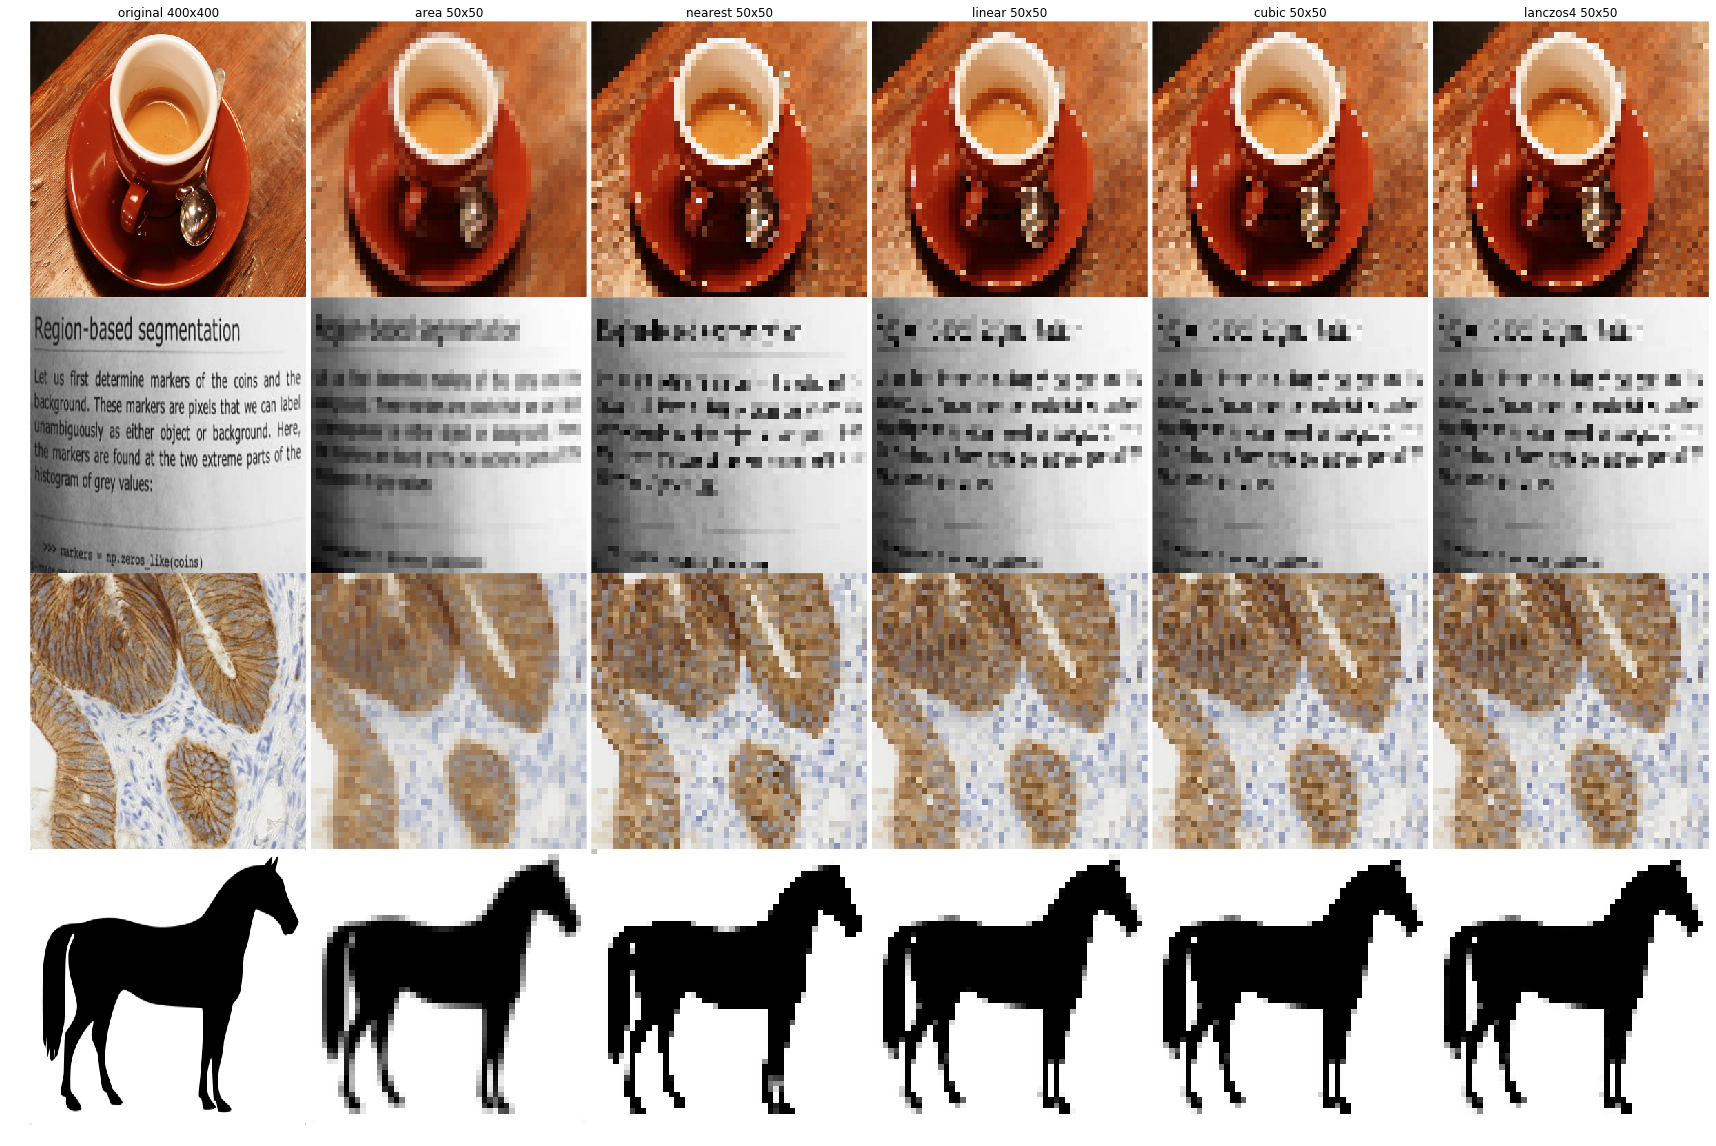

In [4]:
image_set = [[cv2.resize(im, (50,50), interpolation=m[1]) for m in methods] for im in images_orig]
image_set = [[ima,]+imb for ima, imb in zip(images_orig, image_set)]
names = ["original 400x400",] + [m[0]+" 50x50" for m in methods]
display(image_set, names)
# plt.savefig("opencv_interpolation_downsample.jpg", dpi=75)

## Speed comparison
The below plot shows that the linear algorithm is very well optimized and gives nearly the same speed as the nearest algorithm. The more complex algorithms have much more overhead.

In [5]:
n=20
data = []
scale_factors = [0.05, 0.1, 0.3, 0.5, 0.9, 1.1, 1.5, 2, 4, 7, 12]
for m in methods:
    for sf in scale_factors:
        di = []
        for i in range(n):
            t0 = time.time()
            cv2.resize(images_orig[0], (0,0), fx=sf, fy=sf, interpolation=m[1])
            dt = (time.time()-t0)
            di.append(dt)
        dt = np.mean(di)
        err = 2*np.std(di)
        data.append(dict(time=dt, method=m[0], err=err, scale=sf))
data = pd.DataFrame(data)

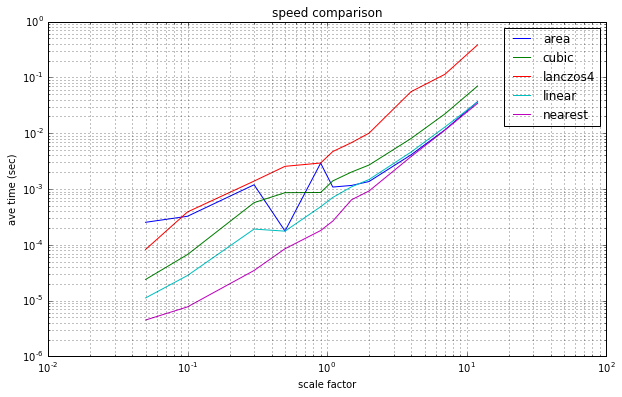

In [6]:
g = data.groupby("method")
plt.figure(figsize(10,6))
for n, gi in g:
    plt.plot(gi["scale"], gi["time"], label=n)
plt.loglog()
plt.legend()
plt.xlabel("scale factor")
plt.ylabel("ave time (sec)")
plt.title("speed comparison")
plt.grid(which="both")
# plt.savefig("opencv_interpolation_speed_plot.jpg", dpi=150)